<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/Costarican_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import time

In [ ]:
pip install featuretools

     |████████████████████████████████| 307kB 8.5MB/s 
     |████████████████████████████████| 706kB 17.2MB/s 
     |████████████████████████████████| 112kB 29.8MB/s 
ERROR: distributed 2021.4.1 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.4.1 has requirement dask>=2021.03.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/Costarican_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/Costarican_test.csv')

In [ ]:
train_labels = np.array(train.pop('Target')).reshape((-1,))
test_ids = list(test.pop('idhogar'))

train, test = train.align(test, axis = 1, join = 'inner')
all_features = list(train.columns)
train.shape

(9557, 141)

In [ ]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

In [ ]:
def model_gbm(features, labels, test_features, test_ids, 
              nfolds = 5, return_preds = False, hyp = None, encoding='ohe'):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    feature_names = list(features.columns)
    
    hyp_OPTaaS = { 'boosting_type': 'dart',
              'colsample_bytree': 0.9843467236959204,
              'learning_rate': 0.11598629586769524,
              'min_child_samples': 44,
              'num_leaves': 49,
              'reg_alpha': 0.35397370408131534,
              'reg_lambda': 0.5904910774606467,
              'subsample': 0.6299872254632797,
              'subsample_for_bin': 60611}

    # Model hyperparameters
#     params = {'boosting_type': 'dart', 
#               'colsample_bytree': 0.88, 
#               'learning_rate': 0.028, 
#                'min_child_samples': 10, 
#                'num_leaves': 36, 'reg_alpha': 0.76, 
#                'reg_lambda': 0.43, 
#                'subsample_for_bin': 40000, 
#                'subsample': 0.54}

    model = lgb.LGBMClassifier(**hyp_OPTaaS, class_weight = 'balanced',
                               objective = 'multiclass', n_jobs = -1, n_estimators = 100)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        # Dataframe for 
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        predictions = predictions.append(fold_predictions)
        
        importances += model.feature_importances_ / nfolds   
        
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances
    return submission, feature_importances, valid_scores

In [ ]:
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)

KeyboardInterrupt: ignored

In [ ]:
results = results.append(pd.DataFrame({'version': ['additional_5fold'], 
                                       'F1-mean': [valid_scores.mean()], 
                                       'F1-std': [valid_scores.std()]}))

In [ ]:
print('train shape:',train.shape,' ', 'test shape:',test.shape)

train shape: (9557, 143)   test shape: (23856, 142)


In [ ]:
data = pd.concat([train, test])

In [ ]:
train_valid = train.loc[train['parentesco1'] == 1, ['idhogar', 'Id', 'Target']].copy()
test_valid = test.loc[test['parentesco1'] == 1, ['idhogar', 'Id']].copy()

In [ ]:
mapping = {'yes':1, 'no':0}

data['dependency'] = data['dependency'].replace(mapping).astype(np.float64)
data['edjefa'] = data['edjefa'].replace(mapping).astype(np.float64)
data['edjefe'] = data['edjefe'].replace(mapping).astype(np.float64)

data[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,33413.000000,33413.000000,33413.000000
mean,1.172238,2.827822,5.170353
std,1.649249,4.606153,5.214174
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [ ]:
data['v18q1'] = data['v18q1'].fillna(0)

# Fill in housholds that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment columns
data['v2a1-missing'] = data['v2a1'].isnull()

# If indivisdual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing vlaue
data['rez_esc_missing'] = data['rez_esc'].isnull()

data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

In [ ]:
# Difference between people living in house and household size
data['hhsize-diff'] = data['tamviv'] - data['hhsize']

elec = []

# Assign values
for i,row in data.iterrows():
  if row['noelec'] == 1:
    elec.append(0)
  elif row['coopele'] == 1:
    elec.append(1)
  elif row['public'] == 1:
    elec.append(2)
  elif row['planpri'] == 1:
    elec.append(3)
  else:
    elec.append(np.nan)

# Record the new variable and missing flag
data['elec'] = elec
data['elec-missing'] = data['elec'].isnull()

# Wall ordinal variable
data['walls'] = np.argmax(np.array(data[['epared1', 'epared2', 'epared3']]), axis=1)
## np.argmax ==> 루트 씌우기

# Roof ordinal variable
data['roof'] = np.argmax(np.array(data[['etecho1', 'etecho2', 'etecho3']]), axis=1)

# Floor ordinal variable
data['floor'] = np.argmax(np.array(data[['eviv1', 'eviv2', 'eviv3']]), axis=1)

# create new feature
data['walls+roof+floor'] = data['walls'] + data['roof'] + data['floor']

# No toilet, no electricity, no floor, no water service, no ceiling
data['warning'] = 1 * (data['sanitario1'] + (data['elec'] == 0) + data['pisonotiene'] + data['abastaguano'] + (data['cielorazo'] == 0))

# Owns a refrigerator, computer, tablet, and television
data['bonus'] = 1 * (data['refrig'] + data['computer'] + (data['v18q1'] > 0) + data['television'])

# Per capita features
data['phone-per-capita'] = data['qmobilephone'] / data['tamviv']
data['tablets-per-capita'] = data['v18q1'] / data['tamviv']
data['rooms-per-capita'] = data['rooms'] / data['tamviv']
data['rent-per-capita'] = data['v2a1'] / data['tamviv']

# Create one feature from the 'instlevel' columns
data['inst'] = np.argmax(np.array(data[[c for c in data if c.startswith('instl')]]), axis=1)

data['escolari/age'] = data['escolari'] / data['age']
data['inst/age'] = data['inst'] / data['age']
data['tech'] = data['v18q'] + data['mobilephone']

print('Data shape:', data.shape)

Data shape: (33413, 162)


In [ ]:
# The gradient boosting machine does not need the squared version of variables it if already has the original variables.
data = data[[x for x in data if not x.startswith('SQB')]]
data = data.drop(columns = ['agesq'])
data.shape

(33413, 153)

In [ ]:
# Remove Highly Correlated Columns
corr_matrix = data.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greatre than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.975)]

print('To drop columns:', to_drop)

To drop columns: ['tamhog', 'hhsize', 'coopele', 'female', 'hogar_total', 'area2', 'elec']


In [ ]:
data = data.drop(columns = to_drop)

# Establish Correct Variable Types
>We need to specify the correct variables types:

* Individual Variables: these are characteristics of each individual rather than the household

1. Boolean: Yes or No (0 or 1)
2. Ordered Discrete: Integers with an ordering

* Household variables
1. Boolean: Yes or No
2. Ordered Discrete: Integers with an ordering
Continuous numeric

Below we manually define the variables in each category. This is a little tedious, but also necessary.

In [ ]:
import featuretools.variable_types as vtypes

ModuleNotFoundError: ignored

In [ ]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing', 'elec-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin','hhsize-diff',
              'elec',  'walls', 'roof', 'floor', 'walls+roof+floor', 'warning', 'bonus',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding',
          'phones-per-capita', 'tablets-per-capita', 'rooms-per-capita', 'rent-per-capita']
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['age', 'escolari', 'rez_esc', 'inst', 'tech']

ind_cont = ['escolari/age', 'inst/age']

In [ ]:
to_remove = []
for l in [hh_ordered, hh_bool, hh_cont, ind_bool, ind_ordered, ind_cont]:
  for c in l:
    if c not in data:
      to_remove.append(c)

NameError: ignored

In [ ]:
for l in [hh_ordered, hh_bool, hh_cont, ind_bool, ind_ordered, ind_cont]:
  for c in to_remove:
    if c in l:
      l.remove(c)

In [ ]:
for variable in (hh_bool + ind_bool):
  data[variable] = data[variable].astype('bool')

In [ ]:
for variable in (hh_cont + ind_cont):
  data[variable] = data[variable].astype(float)

In [ ]:
for variable in (hh_ordered + ind_ordered):
  try:
    data[variable] = data[variable].astype(int)
  except Exception as e:
    print(f'Could not convert {variable} because of missing values.')

In [ ]:
data.dtypes.value_counts().plot.bar(edgecolor='k')
plt.title('Variable Type Distribution')

**엔터티기능 도구 집합에는 모든 테이블과 테이블 간의 관계가 들어 있습니다. 현재는 단일 테이블만 있지만 정규화를 통해 여러 테이블을 만들 수 있습니다. 첫 번째 테이블 데이터에는 개인 레벨과 가구 레벨에 대한 모든 정보가 포함되어 있으므로 이를 호출하겠습니다.**

In [ ]:
es = ft.EntitySet(id = 'households')
es.entity_from_dataframe(entity_id = 'data', dataframe = data, index = 'Id')

In [ ]:
es.normalize_entity(base_entity_id='data', new_entity_id='household', index = 'idhogar', additional_variables= hh_bool + hh_ordered + hh_cont + ['Target'])
es

In [ ]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='household', max_depth=2, verbose=1, n_jobs=-1, chunk_size=100)

In [ ]:
pip install dask

# 다른 커널

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')

In [26]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/Costarican_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/Costarican_test.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [ ]:
test.info()
# object ==> 인코딩할것이 5개로 똑같다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


Text(0.5, 1.0, 'Count of Unique Values in integer Columns')

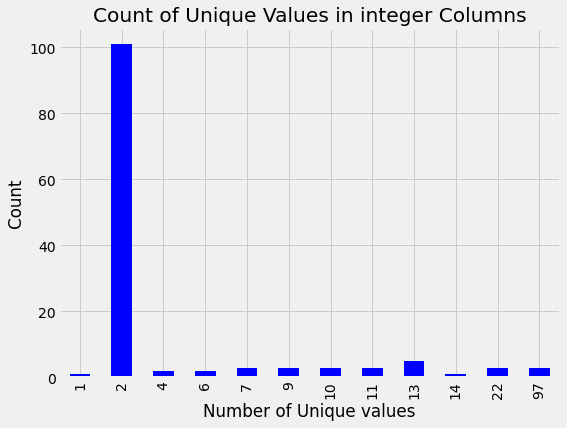

In [ ]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='blue', figsize=(8,6), linewidth=2)
plt.xlabel('Number of Unique values')
plt.ylabel('Count')
plt.title('Count of Unique Values in integer Columns')

Text(0.5, 1.0, 'Count of Unique Values in Integer Columns')

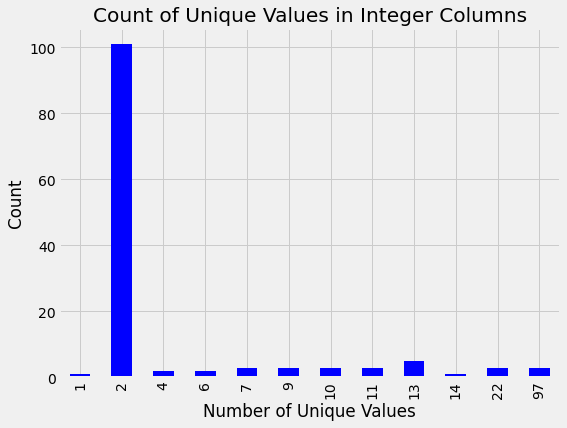

In [ ]:
# 몇개의 개수를 가지는지(컬럼) 알아보는 플롯
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(
    color='blue', figsize=(8,6), linewidth=2)
plt.xlabel('Number of Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Integer Columns')
# booleans(0,1)를 가지는 컬럼들이 많다.

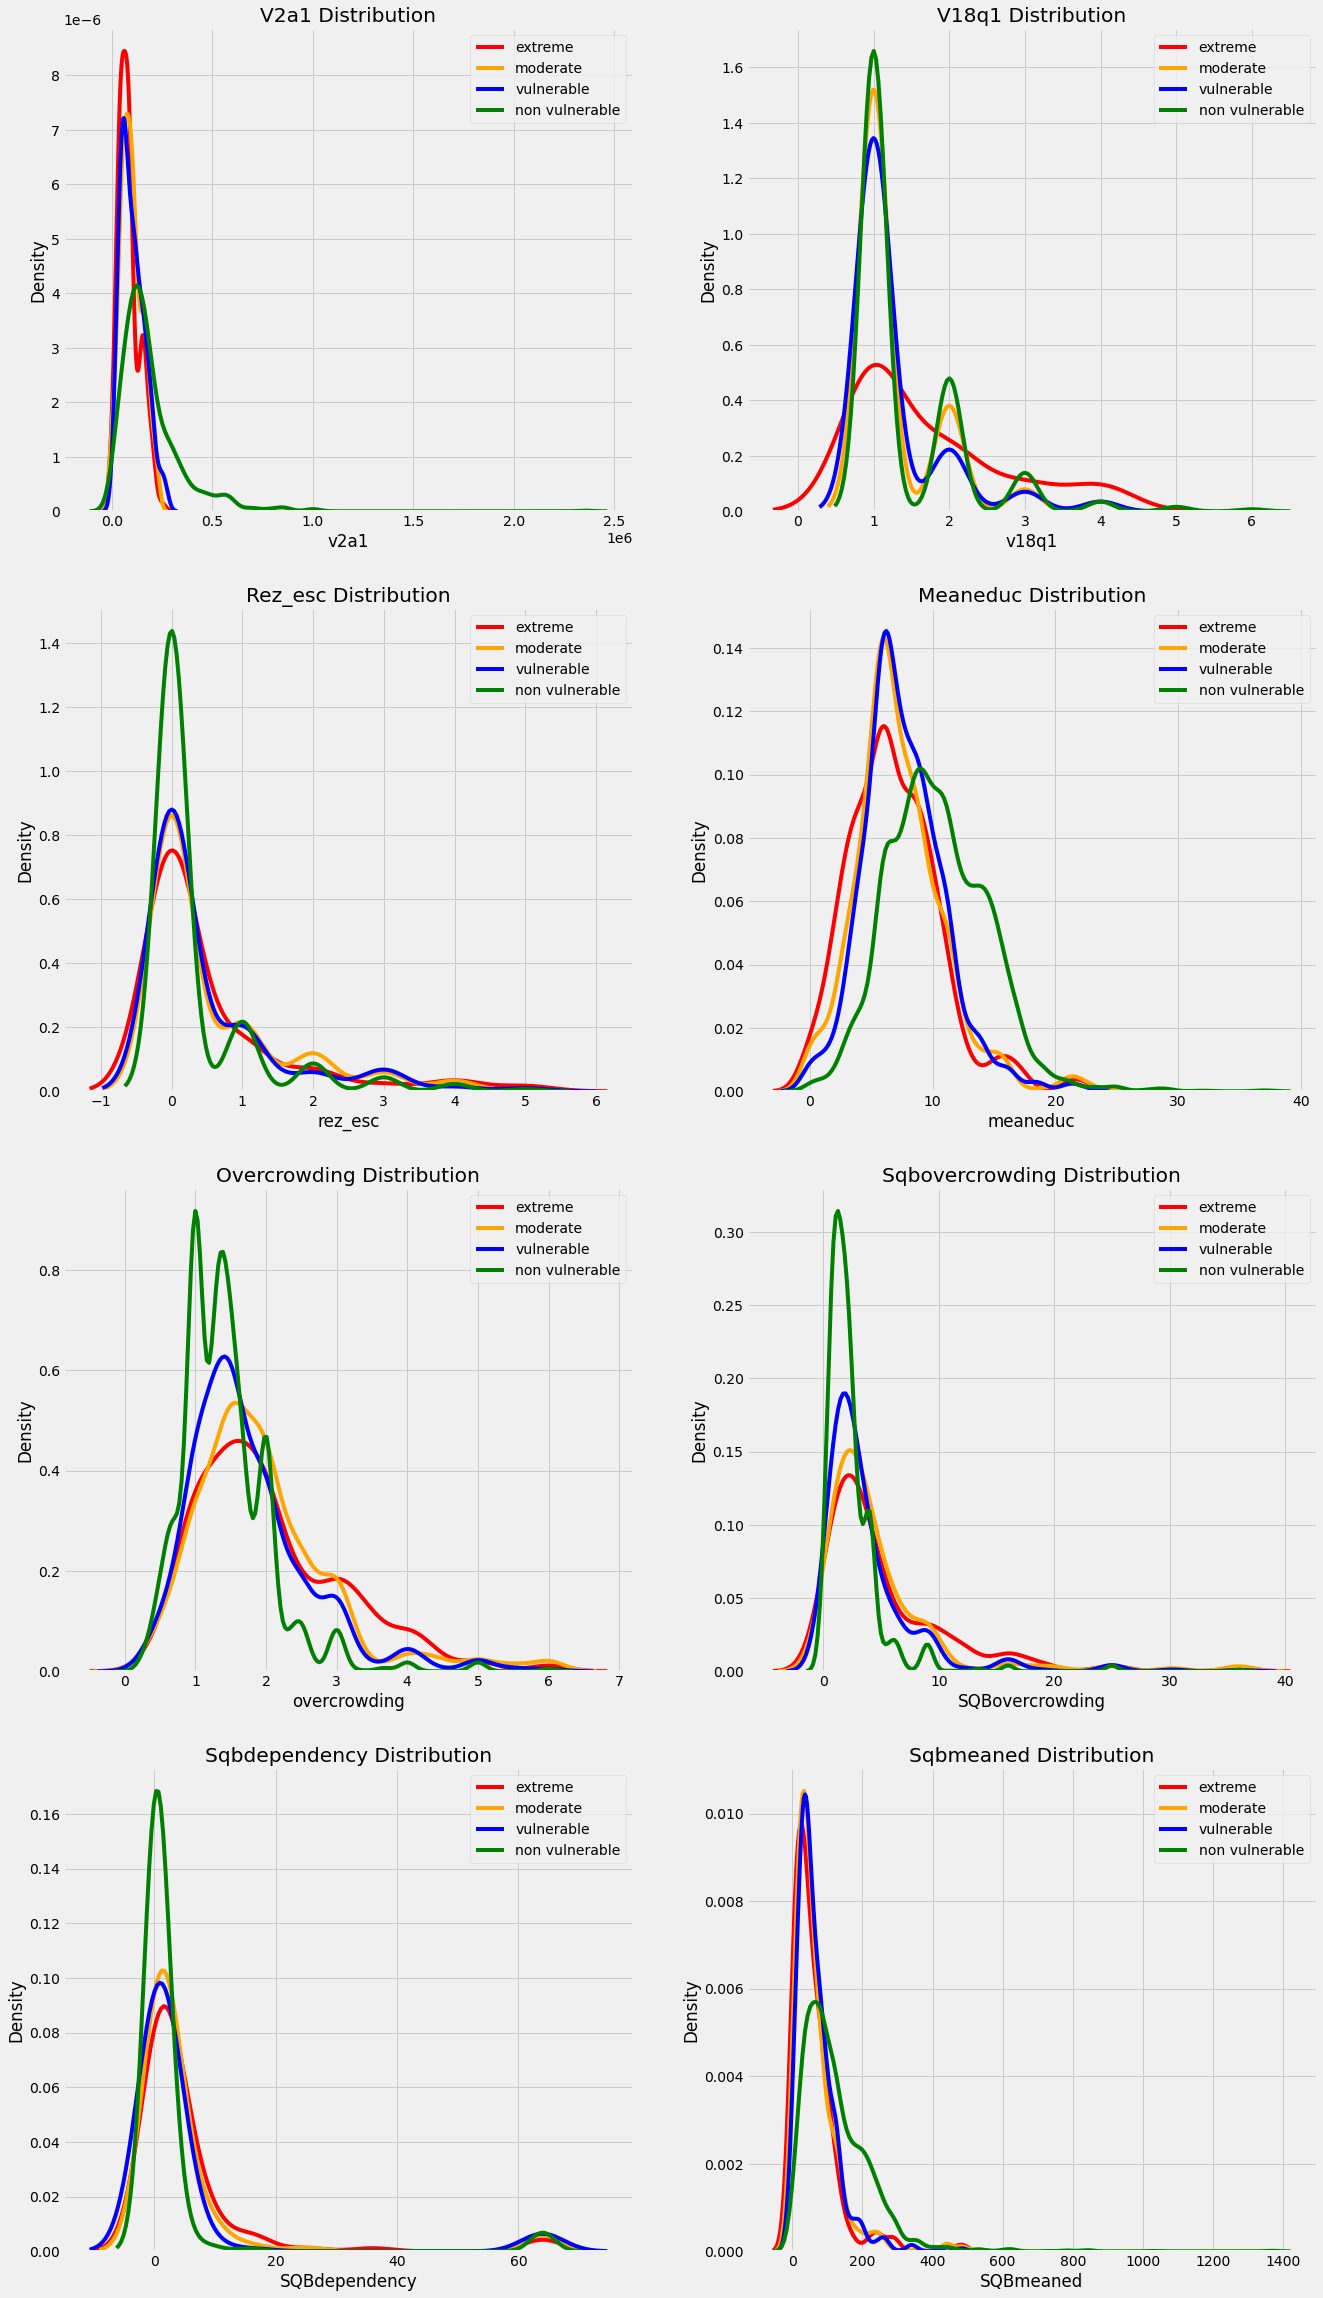

In [27]:
from collections import OrderedDict
plt.figure(figsize=(20,16))

colors = OrderedDict({1:'red', 2:'orange', 3:'blue', 4:'green'})
poverty_mapping = OrderedDict({1:'extreme', 2:'moderate', 3:'vulnerable', 4:'non vulnerable'})

for i, col in enumerate(train.select_dtypes('float')):
  ax = plt.subplot(4,2, i+1)
  for poverty_level, color in colors.items():
    sns.kdeplot(train.loc[train['Target']==poverty_level, col].dropna(), ax=ax, color=color,
                label=poverty_mapping[poverty_level])
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
plt.subplots_adjust(top=2)

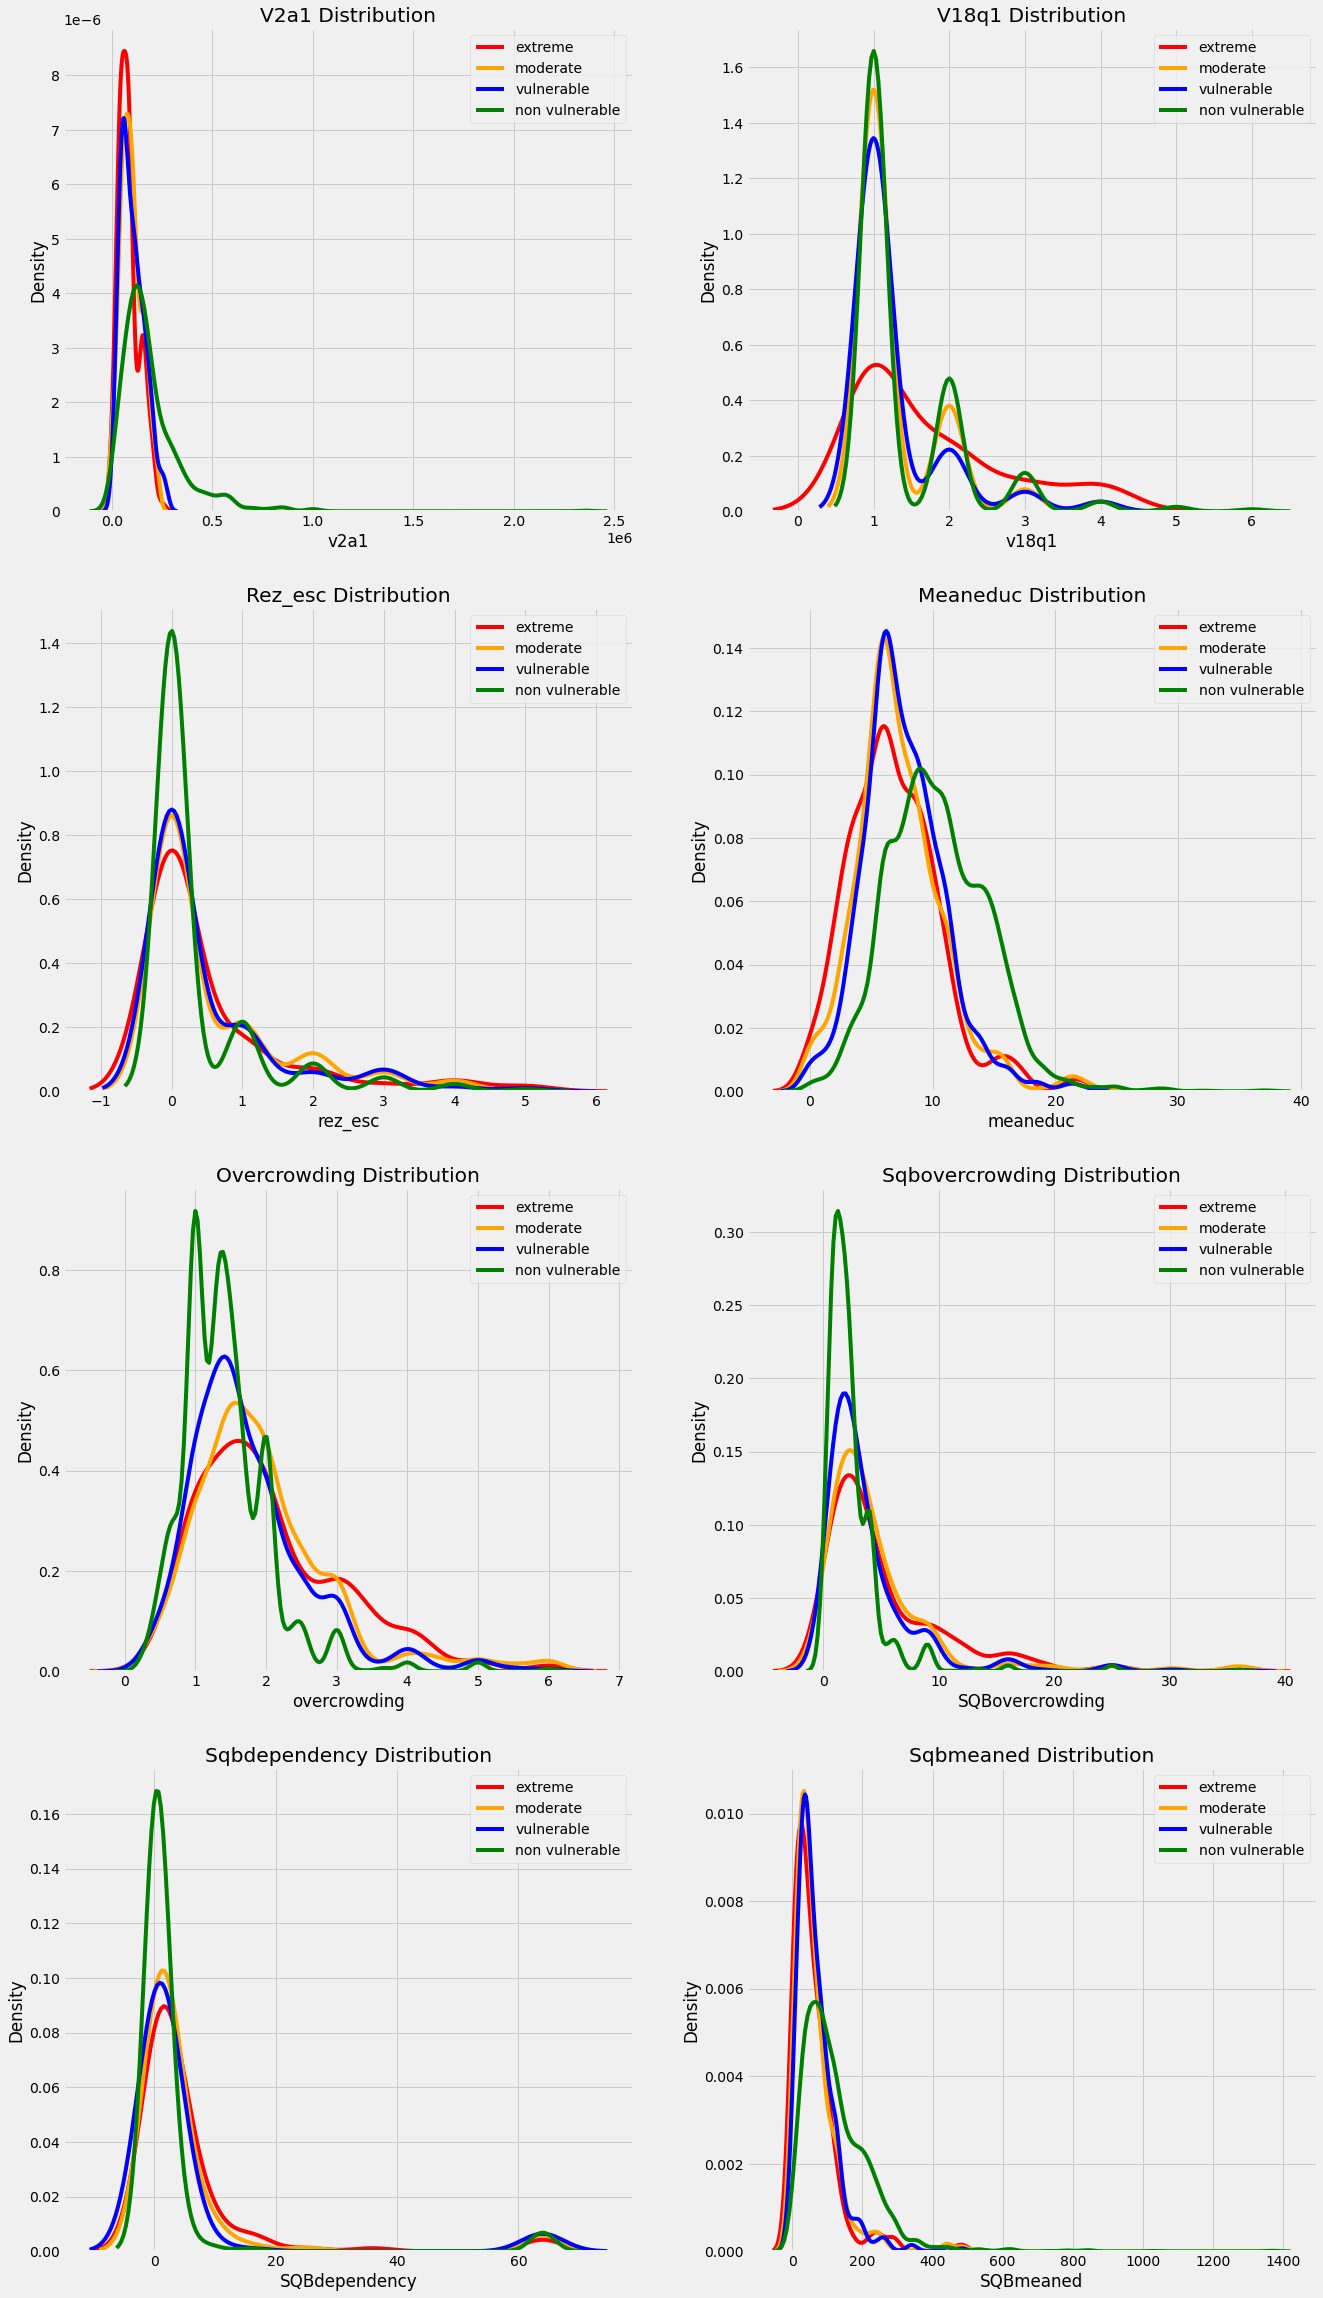

In [ ]:
from collections import OrderedDict
plt.figure(figsize=(20,16))

colors = OrderedDict({1:'red', 2:'orange', 3:'blue', 4:'green'})
poverty_mapping = OrderedDict({1:'extreme', 2:'moderate', 3:'vulnerable', 4:'non vulnerable'})

for i, col in enumerate(train.select_dtypes('float')):
  ax = plt.subplot(4,2, i+1)
  for poverty_level, color in colors.items():
    sns.kdeplot(train.loc[train['Target']==poverty_level, col].dropna(), ax=ax, color=color, 
                label=poverty_mapping[poverty_level])
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    plt.legend()
plt.subplots_adjust(top=2)

나중에 변수와 대상 사이의 상관 관계를 계산하여 형상 사이의 관계를 측정하겠지만, 

이러한 그래프는 어떤 변수가 모형에 가장 "관련성" 있는지 이미 파악할 수 있습니다. 

**예를 들어**, **가정 내 성인의 평균 교육을 나타내는 평균 교육(meaneduc)**은 

빈곤 수준과 관련이 있는 것으로 보인다: 높은 평균 성인 교육은 빈곤 수준이 덜 심각한 목표의 높은 가치로 이어진다. --> 빈곤수준 반비례 성인 교육

In [ ]:
train.select_dtypes('object').head()
# dependency, edjefe, edjefa 를 어떻게 처리할건지

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


In [28]:
mapping = {'yes':1, 'no':0}

for df in [train, test]:
  df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
  df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)
  df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [ ]:
mapping = {'yes':1, 'no':0}

for df in [train, test]:
  df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
  df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)
  df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


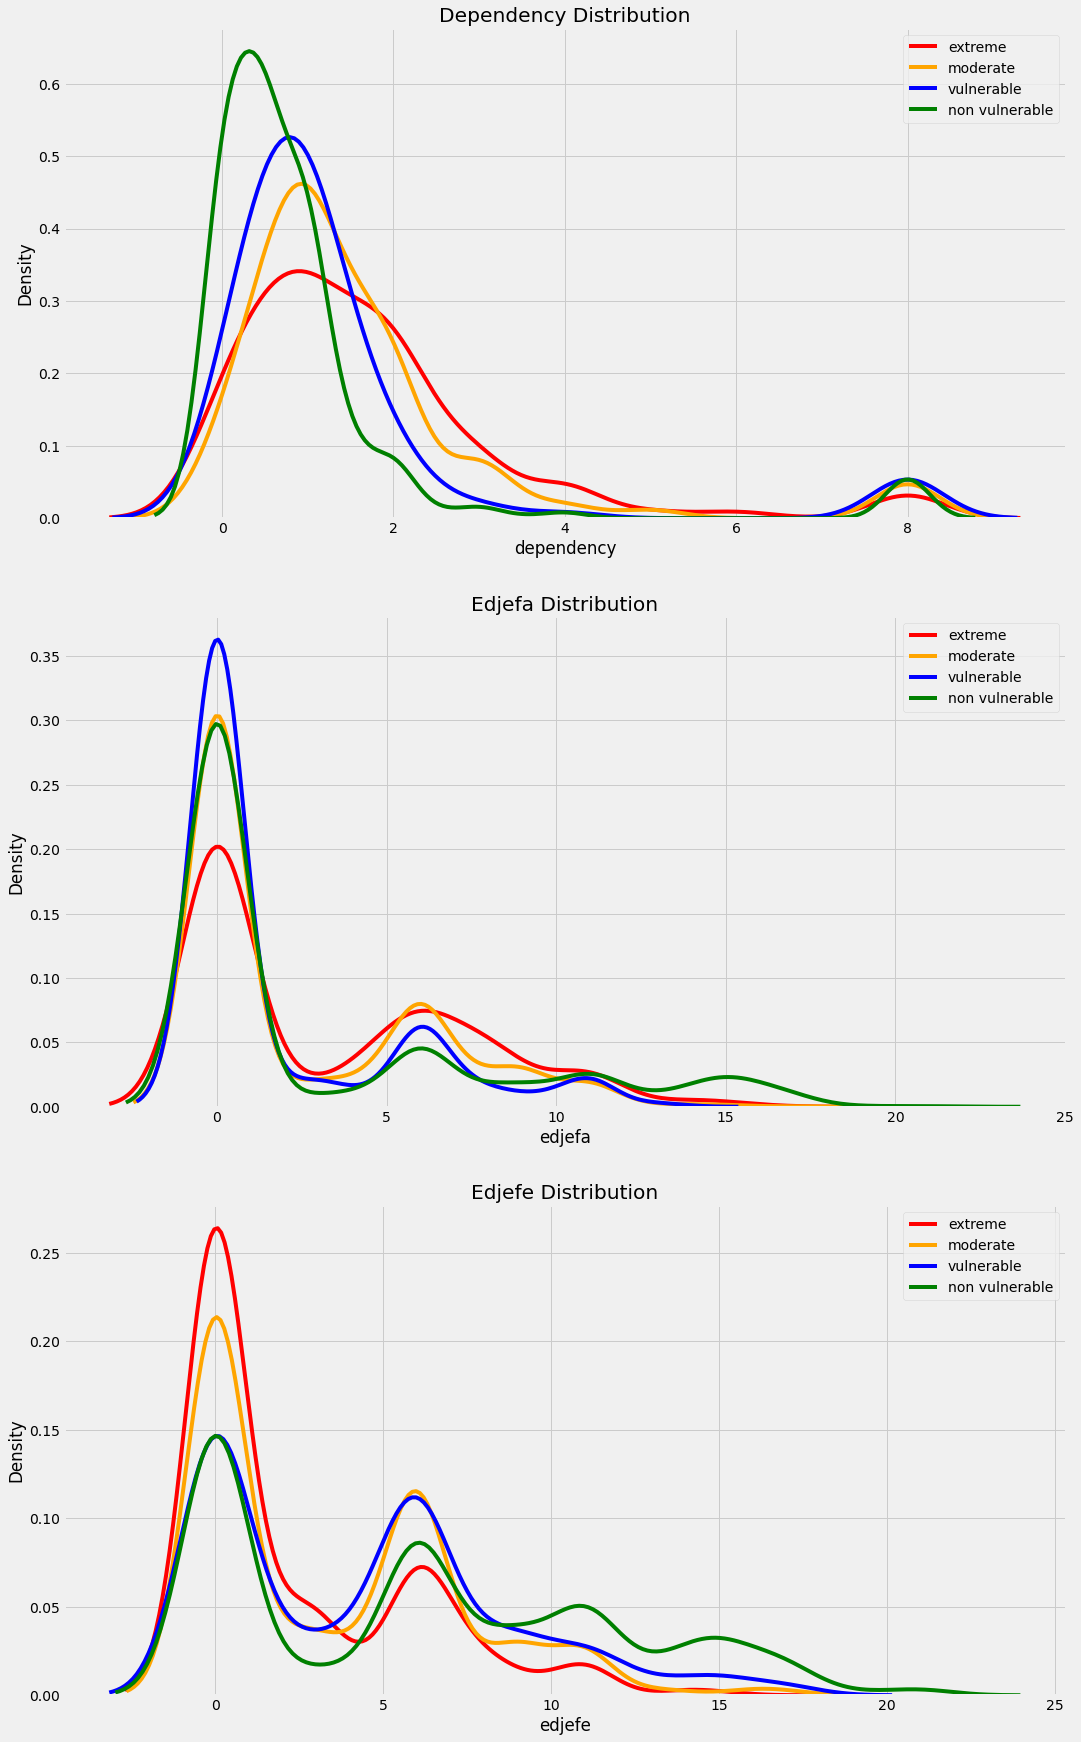

In [ ]:
plt.figure(figsize=(16,12))

for i, c in enumerate(['dependency', 'edjefa', 'edjefe']):
  ax=plt.subplot(3,1, i+1)
  for poverty_level, color in colors.items():
    sns.kdeplot(train.loc[train['Target']==poverty_level, c], ax=ax, color=color, label=poverty_mapping[poverty_level])
    plt.title(f'{c.capitalize()} Distribution')
    plt.xlabel(c)
    plt.ylabel('Density')
    plt.legend()

plt.subplots_adjust(top=2)

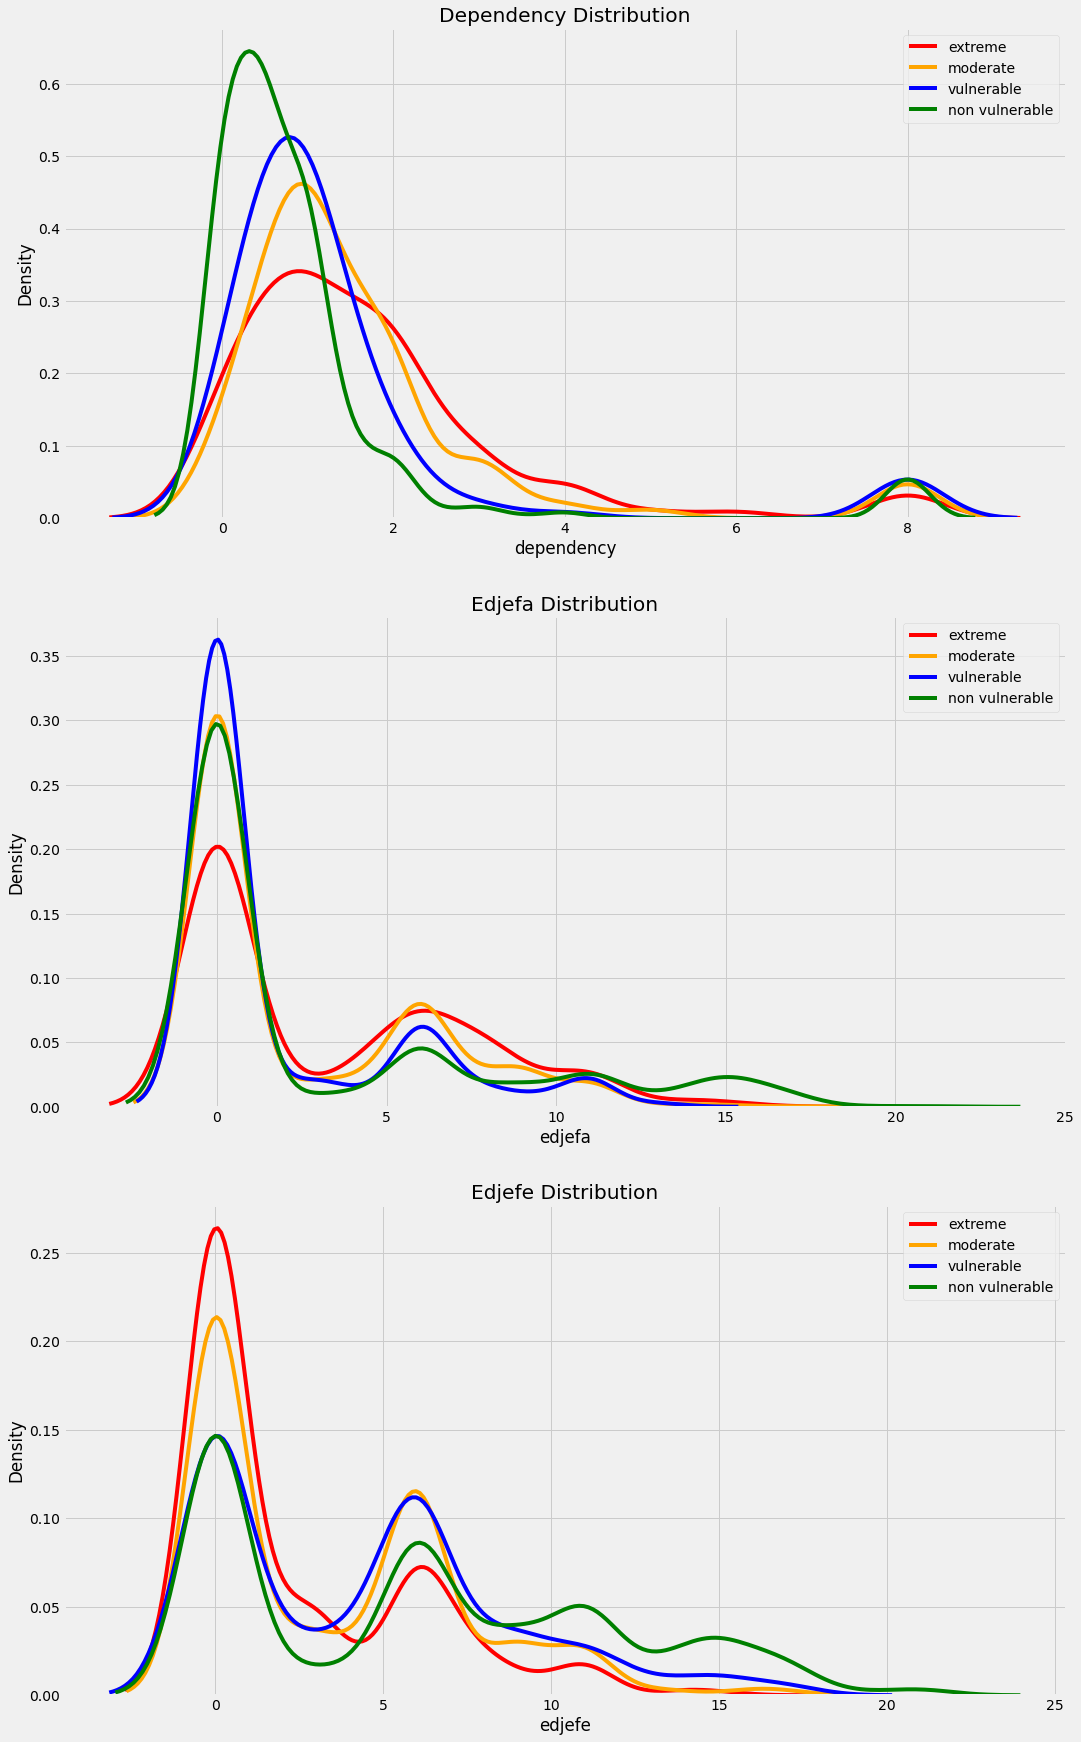

In [ ]:
plt.figure(figsize=(16,12))

for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
  ax = plt.subplot(3,1, i+1)
  for poverty_level, color in colors.items():
    sns.kdeplot(train.loc[train['Target']==poverty_level, col], ax=ax, color=color, label=poverty_mapping[poverty_level])
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    plt.legend()

plt.subplots_adjust(top=2)

In [29]:
test['Target'] = np.NaN
data= train.append(test, ignore_index=True)

In [ ]:
test['Target'] = np.nan
data = train.append(test, ignore_index=True)
# train, test 데이터 합쳐서 피쳐엔지니어링

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

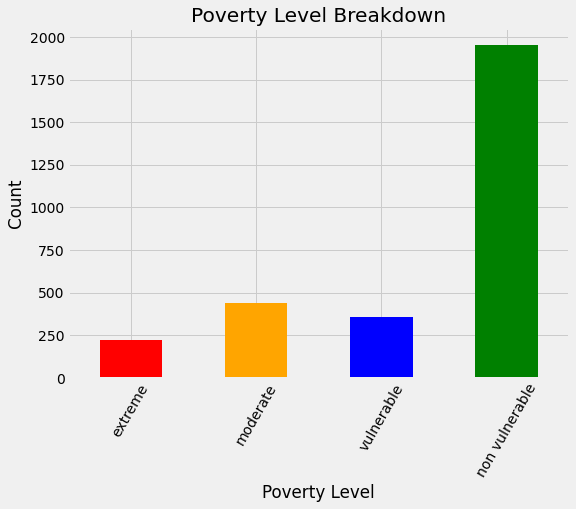

In [30]:
heads = data.loc[data['parentesco1']==1].copy()

train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1']==1), ['Target', 'idhogar']]

label_counts = train_labels['Target'].value_counts().sort_index()

label_counts.plot.bar(figsize=(8,6), color=colors.values(), linewidth=2)
plt.xlabel('Poverty Level')
plt.ylabel('Count')
plt.xticks([x-1 for x in poverty_mapping.keys()], list(poverty_mapping.values()), rotation=60)
plt.title('Poverty Level Breakdown')

label_counts

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

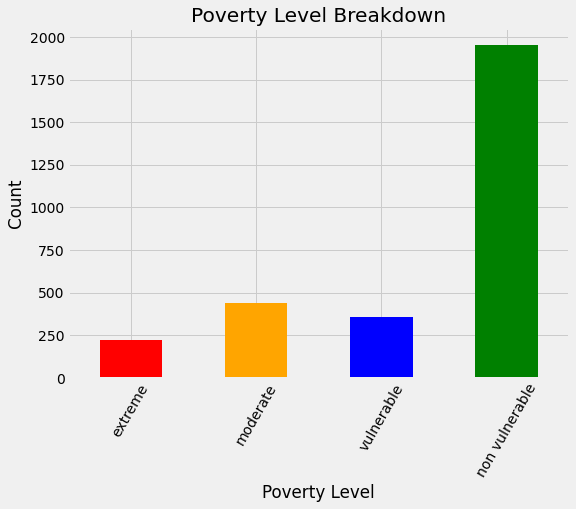

In [ ]:
heads = data.loc[data['parentesco1'] == 1].copy()

train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1']==1), ['Target', 'idhogar']]

label_counts = train_labels['Target'].value_counts().sort_index()

label_counts.plot.bar(figsize=(8,6), color=colors.values(), linewidth=2)

plt.xlabel('Poverty Level')
plt.ylabel('Count')
plt.xticks([x-1 for x in poverty_mapping.keys()], list(poverty_mapping.values()), rotation=60)
plt.title('Poverty Level Breakdown')

label_counts

# Label 오류
실제 문제에서, 우리는 왜 라벨이 잘못되었는지, 그리고 우리 스스로 그 문제를 해결할 방법을 알아내야 할 것이다. 이 섹션은 꼭 필요한 것은 아니지만 레이블과 관련된 문제를 해결합니다. 이 문제를 처리하는 방법을 보여주기 위한 필사


---

# Labels의 오류 해결법
우선 오류를 수정하기 전에 먼저 오류를 찾아야 합니다. 가족 구성원에 대한 레이블이 다른 가구를 찾기 위해 가구별로 데이터를 그룹화한 다음 대상의 고유한 값이 하나만 있는지 확인할 수 있습니다.

In [ ]:
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target' .format(len(not_equal)))

There are 85 households where the family members do not all have the same target


In [35]:
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique()==1)
# 고유 값 한 'idhogar'가 다수의 'Target'값을 가질수 있으니까
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target


In [31]:
train.groupby('idhogar')['Target'].nunique().value_counts()

1    2903
2      84
3       1
Name: Target, dtype: int64

In [36]:
not_equal

idhogar
0172ab1d9    False
03f4e5f4d    False
0511912b6    False
078a0b6e2    False
09e25d616    False
             ...  
e65d4b943    False
efd3aec61    False
f006348ed    False
f7b421c2c    False
f94589d38    False
Name: Target, Length: 85, dtype: bool

In [37]:
# '0172ab1d9'가 가지는 여러가지 값들
train[train['idhogar']==not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


# Correct Errors (오류 해결하기)
Now we can correct labels for the households that do have a head AND the members have different poverty levels.

In [ ]:
for household in not_equal.index:
  true_target = int(train[(train['idhogar']==household) & (train['parentesco1']==1.0)]['Target'])
  train.loc[train['idhogar']==household, 'Target'] = true_target

all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
not_equal = all_equal[all_equal != True]

print(f'There are {len(not_equal)} households where the family members do not all have the same target.')

There are 0 households where the family members do not all have the same target.


In [39]:
# Target에 올바른 값 넣기
for household in not_equal.index:
  true_target = int(train[(train['idhogar']==household) & (train['parentesco1'] == 1.0)]['Target'])

  train.loc[train['idhogar']==household, 'Target'] = true_target

# 증명하려고 다시 all_equal, not_equal 나누기
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

not_equal = all_equal[all_equal != True]

print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


In [40]:
train.loc[train.idhogar=='0172ab1d9'][['idhogar', 'Id', 'parentesco1', 'Target']]
## 아니 그냥 idhogar가 한 집안이라고 생각하면 Target은 다 똑같다고 생각하면 되는거 아닌가?
## 왜 'parentesco1'가 필요한거지? ==> parentesco1는 가장이고 parentesco1가 다르다고 Target도 다르면 안되니까

,idhogar,Id,parentesco1,Target
7651,0172ab1d9,ID_a5e2b0639,0,3
7652,0172ab1d9,ID_5dfdf4ebe,0,3
7653,0172ab1d9,ID_762e1fd96,0,3
7654,0172ab1d9,ID_c76b87004,1,3
7655,0172ab1d9,ID_1dffe3dcf,0,3


# Label 오류 해결 완료

이런 오류 데이터(특히 Target데이터)는 실제 데이터에서 많이 발생한다.

 연습하자!!!, 대비하자!!!



---
# Missing Variables

MNAR(Missing Not At Randomly) 가 아닌 채울수 있는, 이해 할수 있는 결측값 채우기


In [48]:
def missing_data(df):
  total = df.isnull().sum()
  percent = round(df.isnull().sum()/len(df)*100, 2)

  table = pd.concat([total, percent], axis=1, keys=['total', 'percent']).sort_values('percent', ascending=False)
  table = table[table['percent'] != 0]
  return table

In [ ]:
def missing_data(df):
  total = df.isnull().sum()
  percent = round(df.isnull().sum()/len(df)*100, 2)

  table = pd.concat([total, percent], axis=1, keys=['total', 'percent']).sort_values('percent', ascending=False)
  table = table.loc[table['total'] != 0 ]
  return table

In [49]:
missing_data(data)

,total,percent
rez_esc,27581,82.55
v18q1,25468,76.22
v2a1,24263,72.62
Target,23856,71.40
SQBmeaned,36,0.11
meaneduc,36,0.11


# 'v18q1' 결측값

'v18q1'은 가족이 소유한 태블릿 수를 나타냅니다. 

우리는 이 변수의 값 카운트를 볼 수 있습니다. 

이것은 한 집에 대한 변수이기 때문에 가계 차원에서만 보는 것이 타당하기 때문에 

가장을 위한 행만 골라보도록 하겠습니다.

In [52]:
def plot_value_counts(df, col, heads_only=False):
  if heads_only:
    df = df.loc[df['parentesco1'] == 1].copy()

  plt.figure(figsize=(8,6))
  df[col].value_counts().sort_index().plot.bar(color='blue', linewidth=2)
  plt.xlabel(f'{col}')
  plt.title(f'{col} Value counts')
  plt.ylabel('Count')

In [ ]:
def plot_value_counts(df, col, heads_only=False):
  if heads_only:
    df = df.loc[df['parentesco1'] == 1].copy()

  plt.figure(figsize=(8,6))
  df[col].value_counts().sort_index().plot.bar(color='blue', linewidth=2)
  plt.xlabel(f'{col}')
  plt.title(f'{col} Value counts')
  plt.ylabel('Count')

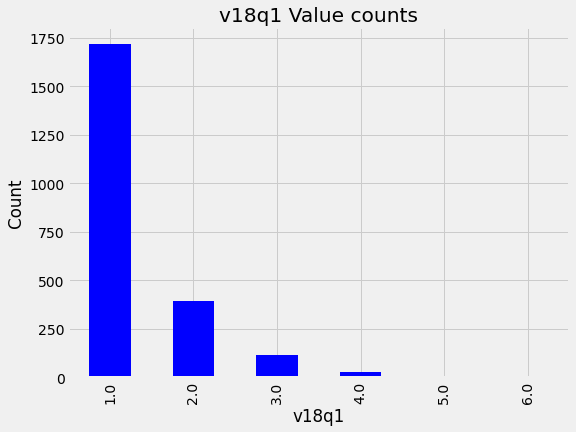

In [53]:
plot_value_counts(heads, 'v18q1')

In [ ]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())
# 타블렛을 가지는 집안은 무조건 타블렛을 가진다는 결론.==> v18q가 1이면 v18q1은 값을 가진다.(가장중에서)

v18q
0    8044
1       0
Name: v18q1, dtype: int64

In [54]:
data['v18q1'] = data['v18q1'].fillna(0)

# 'v2a1' 결측값 채우기

'v2a1' which represents the montly rent payment

'tipovivi_' 와 관련있다.

Text(0.5, 1.0, 'Home Ownership Status for Households Missing Rent Payments')

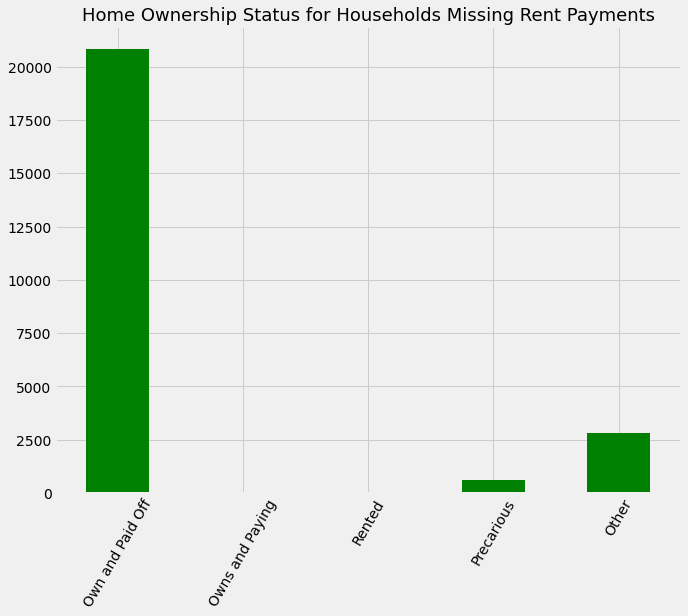

In [ ]:
own_variables = [x for x in data if x.startswith('tipo')]

data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize=(10,8), color='green', linewidth=2)
plt.xticks([0,1,2,3,4], ['Own and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
           rotation=60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size=18)

In [ ]:
data.loc[(data['tipovivi1']==1), 'v2a1'] = 0

data['v2a1-missing'] = data['v2a1'].isnull()
data['v2a1-missing'].value_counts()
# 그래도 남았다.

False    29994
True      3419
Name: v2a1-missing, dtype: int64

# 'rez_esc' 결측치 채우기 
==> years behind in school





In [ ]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

이것이 말해주는 것은 결측치가 있는 가장 오래된 나이는 17세라는 것입니다.

 이것보다 나이가 많은 사람이라면, 우리는 그들이 단순히 학교에 있지 않다고 가정할 수 있을 것이다.
 
  Missing_values를 가진 사람들의 나이를 살펴봅시다.

In [ ]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

this variable is only defined for individuals between 7 and 19.

therefore the value should be set to 0

In [ ]:
missing_data(data)

,total,percent
rez_esc,27581,82.55
Target,23856,71.40
v2a1,3419,10.23
SQBmeaned,36,0.11
meaneduc,36,0.11


In [ ]:
data.loc[((data['age']>19) | (data['age']<7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

data['rez_esc-missing'] = data['rez_esc'].isnull()

In [ ]:
# Outlier 를 상한값으로 처리
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

In [ ]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

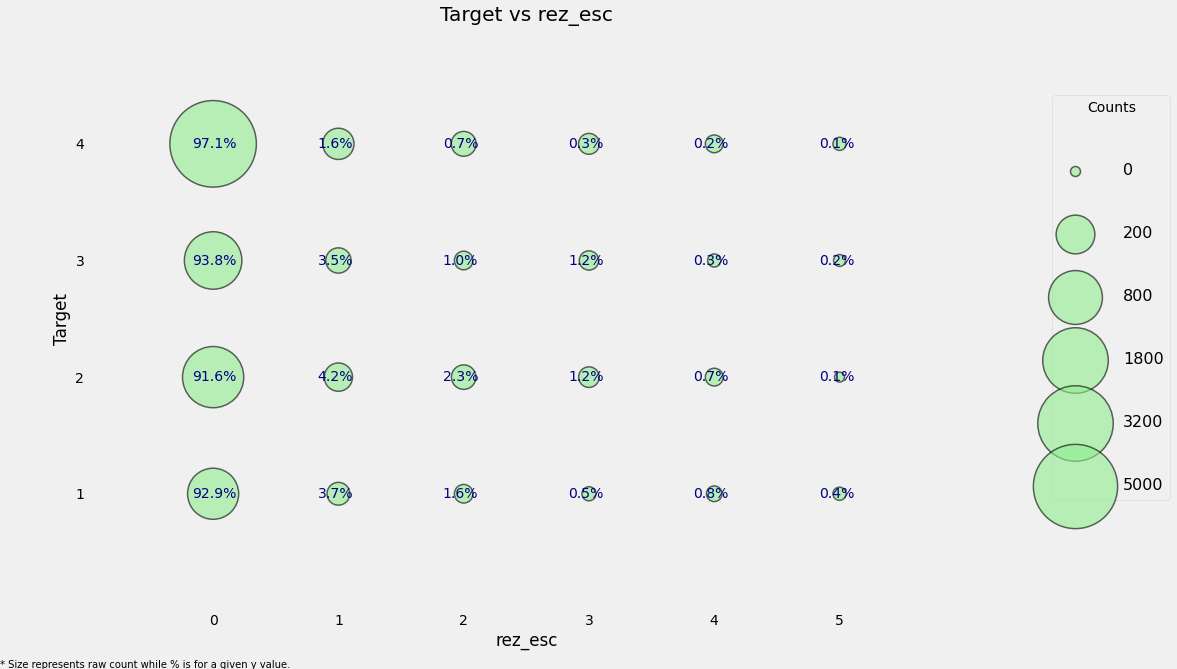

In [ ]:
plot_categoricals('rez_esc', 'Target', data)

In [ ]:
missing_data(data)

,total,percent
Target,23856,71.40
v2a1,3419,10.23
rez_esc,1161,3.47
SQBmeaned,36,0.11
meaneduc,36,0.11
